In [19]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader

In [20]:
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
print(f"using device : {device}")

using device : cpu


In [21]:
torch.manual_seed(42)

In [22]:
df=pd.read_csv('fashion-mnist_train.csv')
df.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [23]:
df.shape

(60000, 785)

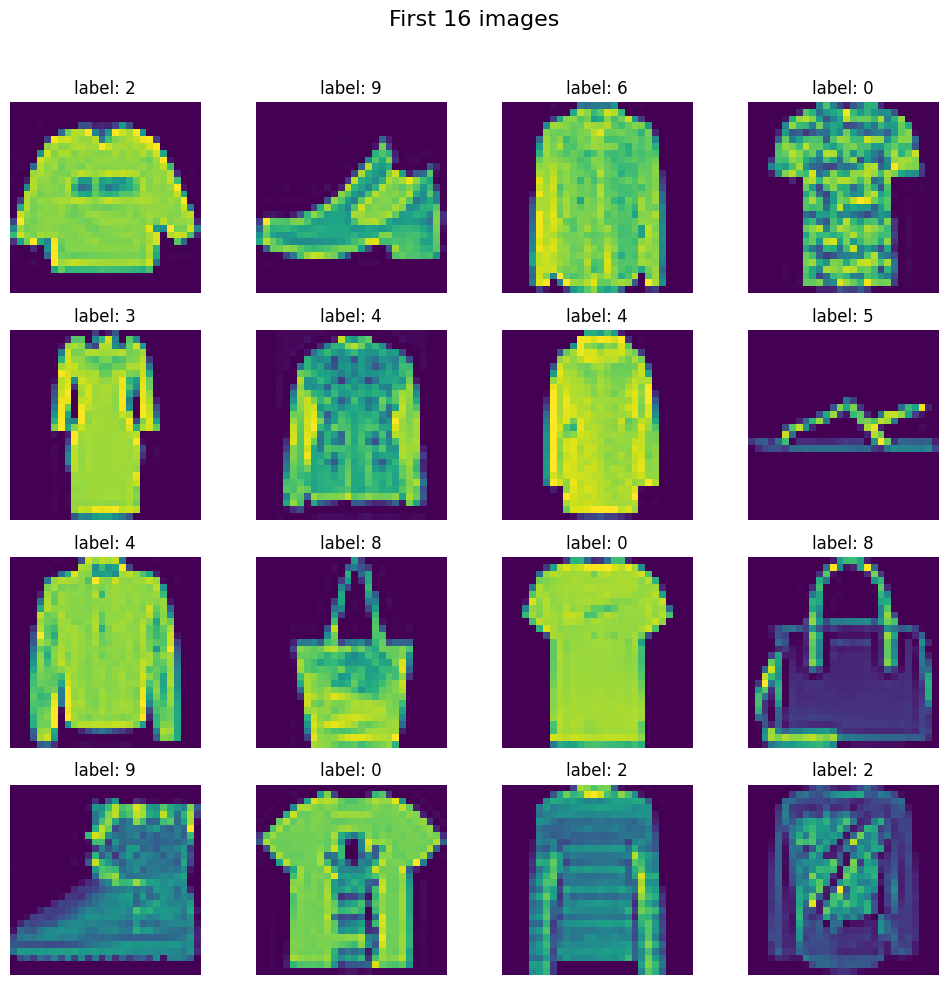

In [24]:
fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 images",fontsize=16)
for i,ax in enumerate(axes.flat):
    img=df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"label: {df.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [25]:
X=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [26]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [27]:
X_train=X_train/255.0
X_test=X_test/255.0

In [28]:
X_train.shape

(48000, 784)

In [29]:
class CustomDataset(Dataset):

  def __init__(self,features,labels) -> None:
     self.features=torch.tensor(features,dtype=torch.float32).reshape(-1,1,28,28,)
     self.labels=torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features  )

  def __getitem__(self,index):
    return self.features[index],self.labels[index]



In [30]:
train_dataset=CustomDataset(X_train,y_train)

In [31]:
len(train_dataset)


48000

In [32]:
test_dataset=CustomDataset(X_test,y_test)

In [54]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [55]:
import optuna


In [61]:
class MyNN(nn.Module):

  def __init__(self,input_features):

    super().__init__()
    self.features=nn.Sequential(
        nn.Conv2d(input_features,32,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(32,64,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2,stride=2)
        )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*7*7,128),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(64,10)
    )


  def forward(self,X):
      X=self.features(X)
      X=self.classifier(X)
      return X

In [62]:
learning_rate=0.1
epochs=50

In [63]:
model=MyNN(1)

#optimizer
criterian=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)


In [65]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterian(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.6990847441951434
Epoch: 2 , Loss: 0.4910012654364109
Epoch: 3 , Loss: 0.4069804260482391
Epoch: 4 , Loss: 0.3656483698412776
Epoch: 5 , Loss: 0.3298042442500591
Epoch: 6 , Loss: 0.30883617503816885
Epoch: 7 , Loss: 0.2896596563545366
Epoch: 8 , Loss: 0.2793210188659529
Epoch: 9 , Loss: 0.2624832860330741
Epoch: 10 , Loss: 0.2535320444044967
Epoch: 11 , Loss: 0.23849173782020808
Epoch: 12 , Loss: 0.24029773571528495
Epoch: 13 , Loss: 0.22757914972802004
Epoch: 14 , Loss: 0.22845219395806393
Epoch: 15 , Loss: 0.21669817407305042
Epoch: 16 , Loss: 0.21067153960342208
Epoch: 17 , Loss: 0.20414883790661892
Epoch: 18 , Loss: 0.20547936382175733
Epoch: 19 , Loss: 0.19805280720690885
Epoch: 20 , Loss: 0.198712475558122
Epoch: 21 , Loss: 0.19206880437334378
Epoch: 22 , Loss: 0.18557461822964252
Epoch: 23 , Loss: 0.179540402171202
Epoch: 24 , Loss: 0.17798720711780092
Epoch: 25 , Loss: 0.1737601338752235
Epoch: 26 , Loss: 0.17094199188395093
Epoch: 27 , Loss: 0.172530715602760

In [36]:
model.eval()

{'num_hidden_layers': 1, 'neurons_per_layer': 112, 'epochs': 50, 'learning_rate': 0.0007195925156592745, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 0.0002054999073818931}
0.8838333333333334


In [66]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.90525


In [67]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9599375
